# Imports

In [1]:
# install additional packages if running on Emscripten
import platform

notebook_platform = platform.uname()
if notebook_platform.system == "Emscripten":
    import piplite

    await piplite.install(["openpyxl", "seaborn"])

In [2]:
from enum import Enum
import re
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

sns.set_style("ticks", {"axes.grid": True})

# Data

In [3]:
this_file = pathlib.Path().absolute()
data_dir = this_file.parent / "data"
data_dir

PosixPath('/home/grzanka/workspace/tld_let_calibration/data')

## Monte-Carlo results

In [4]:
import json
from pathlib import Path
from dataclasses import dataclass
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

In [5]:
@dataclass
class Result1D:
    x_values: List[float]
    y_values: List[float]
    x_name: str
    y_name: str
    x_unit: str
    y_unit: str

    # shorter string representation, including length of data for x and y values
    def __repr__(self):
        return f"Result1D({self.x_name} ({len(self.x_values)}), {self.y_name} ({len(self.y_values)}))"

In [6]:
def list_of_estimators(json_filepath: Path) -> List[str]:
    estimators = []
    with open(json_filepath) as f:
        bp_mc_data_sh12a = json.load(f)
        estimators = [estimator["name"] for estimator in bp_mc_data_sh12a["estimators"]]
    return estimators


def list_of_pages(json_filepath: Path, estimator_name: str) -> List[str]:
    pages = []
    with open(json_filepath) as f:
        bp_mc_data_sh12a = json.load(f)
        for estimator in bp_mc_data_sh12a["estimators"]:
            if estimator["name"] == estimator_name:
                pages = [page["name"] for page in estimator["pages"]]
    return pages


def get_data_1d(json_filepath: Path, estimator_name: str, page_name: str) -> Result1D:
    result = Result1D([], [], "", "", "", "")
    with open(json_filepath) as f:
        bp_mc_data_sh12a = json.load(f)
        for estimator in bp_mc_data_sh12a["estimators"]:
            if estimator["name"] == estimator_name:
                for page in estimator["pages"]:
                    if page["name"] == page_name:
                        result.x_values = page["axisDim1"]["values"]
                        result.y_values = page["data"]["values"]
                        result.x_name = page["axisDim1"]["name"]
                        result.y_name = page["data"]["name"]
                        result.x_unit = page["axisDim1"]["unit"]
                        result.y_unit = page["data"]["unit"]
    return result

In [7]:
bp_mc_data_file_sh12a = data_dir / "raw" / "ifj_calibration" / "results_bp.json"
bp_mc_data_file_sh12a

PosixPath('/home/grzanka/workspace/tld_let_calibration/data/raw/ifj_calibration/results_bp.json')

In [8]:
list_of_estimators(bp_mc_data_file_sh12a)

['z_profile',
 'yz_profile',
 'slab_at_0mm',
 'slab_at_15mm',
 'slab_at_27mm',
 'slab_at_28mm',
 'xy_profile_entry']

In [9]:
list_of_pages(bp_mc_data_file_sh12a, estimator_name="z_profile")

['Dose',
 'FluenceProtons',
 'FluencePrimaries',
 'FluenceSecondaryProtons',
 'KineticEnergyProtons',
 'KineticEnergyPrimaries',
 'KineticEnergySecondaryProtons',
 'BetaProtons',
 'BetaPrimaries',
 'KineticEnergyDoseSpectrum',
 'KineticEnergyFluenceSpectrum',
 'dLETProtons',
 'dLETPrimaries',
 'dLETAll',
 'tLETProtons',
 'tLETPrimaries',
 'tLETAll']

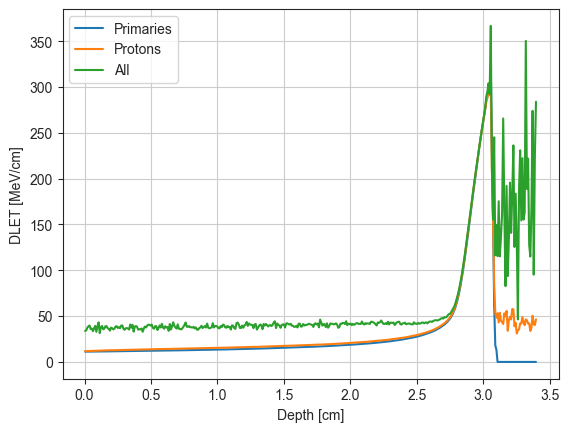

In [19]:
dLETPrimaries = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="dLETPrimaries")
dLETProtons = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="dLETProtons")
dLETAll = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="dLETAll")

fig, ax = plt.subplots()
ax.plot(dLETPrimaries.x_values, dLETPrimaries.y_values, label="Primaries")
ax.plot(dLETProtons.x_values, dLETProtons.y_values, label="Protons")
ax.plot(dLETAll.x_values, dLETAll.y_values, label="All")
ax.set_xlabel(f"Depth [cm]")
ax.set_ylabel(f"{dLETPrimaries.y_name} [{dLETPrimaries.y_unit}]")
ax.grid(True)
ax.legend();

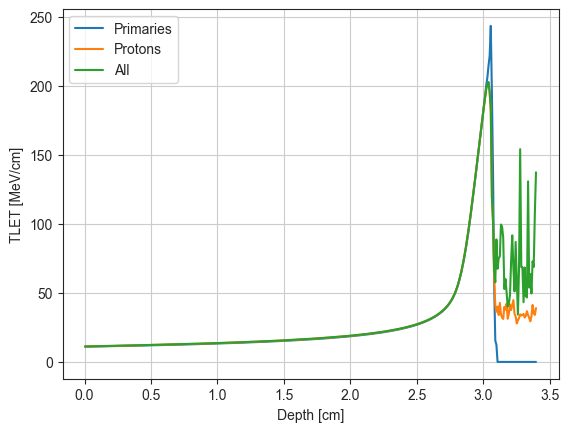

In [20]:
tLETPrimaries = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="tLETPrimaries")
tLETProtons = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="tLETProtons")
tLETAll = get_data_1d(bp_mc_data_file_sh12a, estimator_name="z_profile", page_name="tLETAll")

fig, ax = plt.subplots()
ax.plot(tLETPrimaries.x_values, tLETPrimaries.y_values, label="Primaries")
ax.plot(tLETProtons.x_values, tLETProtons.y_values, label="Protons")
ax.plot(tLETAll.x_values, tLETAll.y_values, label="All")
ax.set_xlabel(f"Depth [cm]")
ax.set_ylabel(f"{tLETPrimaries.y_name} [{tLETPrimaries.y_unit}]")
ax.grid(True)
ax.legend();

In [22]:
df = pd.DataFrame(
    {
        "dLETPrimaries": dLETPrimaries.y_values,
        "dLETProtons": dLETProtons.y_values,
        "dLETAll": dLETAll.y_values,
        "tLETPrimaries": tLETPrimaries.y_values,
        "tLETProtons": tLETProtons.y_values,
        "tLETAll": tLETAll.y_values,
    }
)
df.insert(0, "z_mm", dLETPrimaries.x_values)
df["z_mm"] = df.z_mm * 10
df

,z_mm,dLETPrimaries,dLETProtons,dLETAll,tLETPrimaries,tLETProtons,tLETAll
0,0.0425,11.233821,11.653988,33.793116,11.088836,11.120365,11.183762
1,0.1275,11.233902,11.798190,34.372266,11.088866,11.132269,11.206402
2,0.2125,11.225753,11.776805,37.274354,11.088759,11.134836,11.216547
3,0.2975,11.263976,11.898311,38.985214,11.128831,11.183236,11.270266
4,0.3825,11.274557,11.932564,39.735206,11.132698,11.190363,11.279160
...,...,...,...,...,...,...,...
395,33.6175,0.000000,37.412639,169.461413,0.000000,33.090357,49.518208
396,33.7025,0.000000,50.370429,273.960643,0.000000,41.214143,72.834895
397,33.7875,0.000000,41.008376,95.217195,0.000000,35.161818,68.752624
398,33.8725,0.000000,40.251085,223.980589,0.000000,34.007837,107.636066


In [23]:
df.to_csv(data_dir / "interim" / "mc.csv", index=False)

# Check data from CSV

In [24]:
df_mc = pd.read_csv(data_dir / "interim" / "mc.csv")
df_mc

,z_mm,dLETPrimaries,dLETProtons,dLETAll,tLETPrimaries,tLETProtons,tLETAll
0,0.0425,11.233821,11.653988,33.793116,11.088836,11.120365,11.183762
1,0.1275,11.233902,11.798190,34.372266,11.088866,11.132269,11.206402
2,0.2125,11.225753,11.776805,37.274354,11.088759,11.134836,11.216547
3,0.2975,11.263976,11.898311,38.985214,11.128831,11.183236,11.270266
4,0.3825,11.274557,11.932564,39.735206,11.132698,11.190363,11.279160
...,...,...,...,...,...,...,...
395,33.6175,0.000000,37.412639,169.461413,0.000000,33.090357,49.518208
396,33.7025,0.000000,50.370429,273.960643,0.000000,41.214143,72.834895
397,33.7875,0.000000,41.008376,95.217195,0.000000,35.161818,68.752624
398,33.8725,0.000000,40.251085,223.980589,0.000000,34.007837,107.636066


In [25]:
# Reshaping the DataFrame using melt
df_melted = pd.melt(df_mc, id_vars="z_mm", var_name="LET_Type", value_name="LET")
df_melted["averaging"] = df_melted["LET_Type"].apply(lambda x: x[0])
df_melted["particles"] = df_melted["LET_Type"].apply(lambda x: x[4:])
df_melted = df_melted.drop(columns="LET_Type")
df_melted

,z_mm,LET,averaging,particles
0,0.0425,11.233821,d,Primaries
1,0.1275,11.233902,d,Primaries
2,0.2125,11.225753,d,Primaries
3,0.2975,11.263976,d,Primaries
4,0.3825,11.274557,d,Primaries
...,...,...,...,...
2395,33.6175,49.518208,t,All
2396,33.7025,72.834895,t,All
2397,33.7875,68.752624,t,All
2398,33.8725,107.636066,t,All


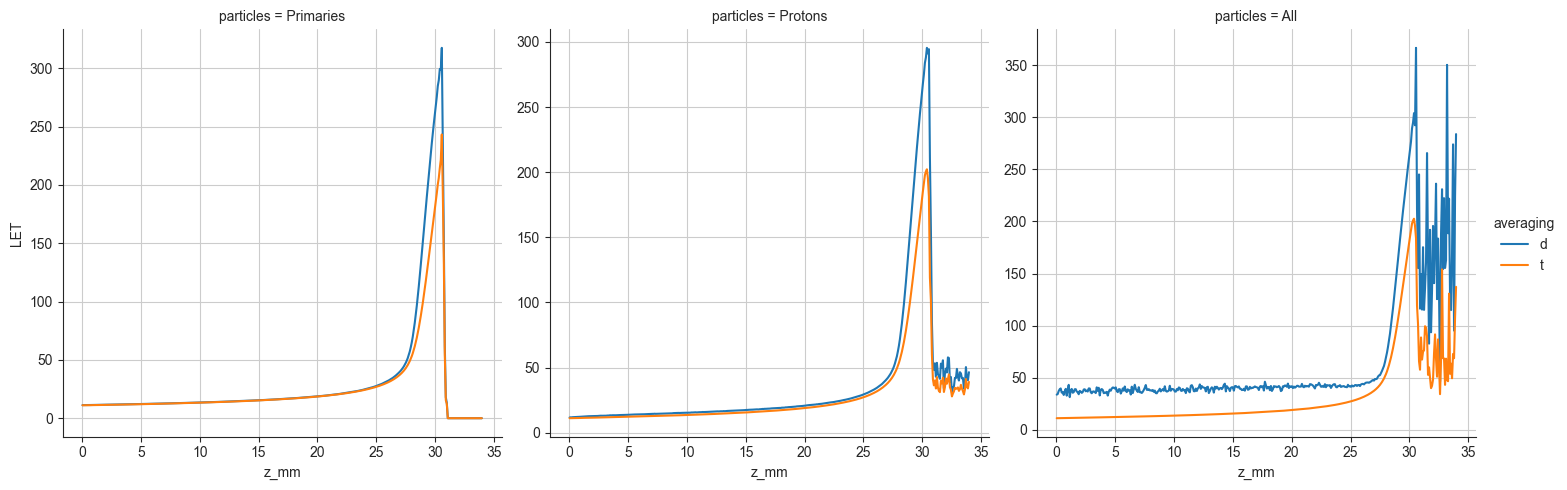

In [26]:
sns.relplot(
    data=df_melted, x="z_mm", y="LET", hue="averaging", col="particles", kind="line", facet_kws=dict(sharey=False)
)

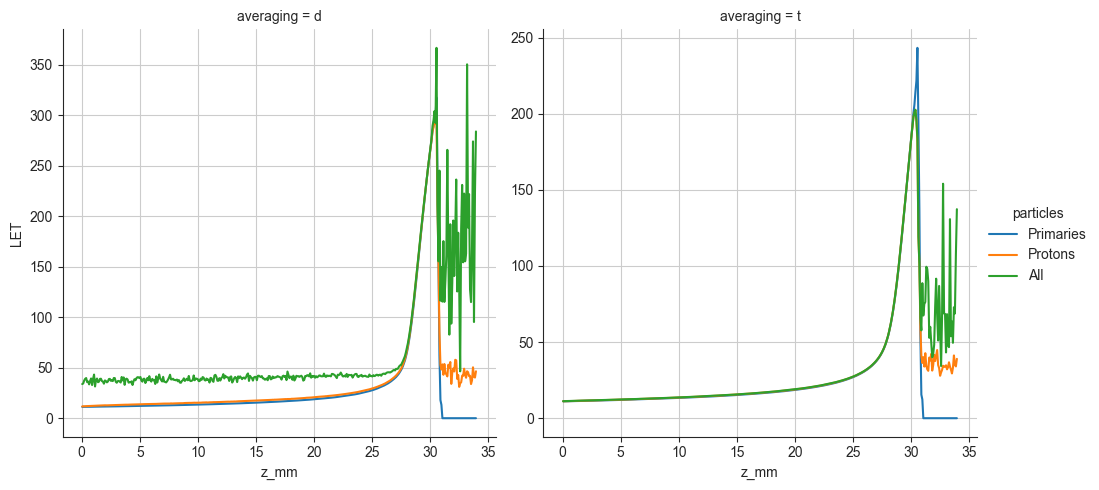

In [27]:
sns.relplot(
    data=df_melted, x="z_mm", y="LET", hue="particles", col="averaging", kind="line", facet_kws=dict(sharey=False)
)